# Project

In [276]:
#  imports and set magics
import numpy as np
import pandas as pd
import json
import tqdm
import time
import datetime
import os
import requests
from bs4 import BeautifulSoup
import re
import pyarrow

# Project

**Authors:** 
* Jørgen Baun Høst, pjz633@alumni.ku.dk
* Marius Heltberg Lassen, pgb206@alumni.ku.dk

This notebook contains the data extraction, data structuring and manipulation, calculations and figures for our project *Liar, liar, pants on fire? Fake news detection with supervised machine learning*.

Dependencies:

In [277]:
# %pip install

## Web scraping 

### Define functions:

General functions:

In [278]:
def log(response: requests.Response):
    """
    Creates or appends a log-file with information from a `requests.get()`-call.
    
    The information gathered is:
    - - - - - - - -
        timestamp   :   Current local time.
        status_code :   Status code from requests call.
        length      :   Length of the HTML-string.
        output_path :   Current working directory.
        url         :   The URL of the response.
    """

    # Open or create the csv file
    if os.path.isfile('log'):
        log = open('log','a')
    else: 
        log = open('log','w')
        header = ['timestamp', 'status_code', 'length', 'output_file', 'url'] # Header names
        log.write(';'.join(header) + "\n")
        
    # Gather log information
    status_code = response.status_code # Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) # Local time
    length = len(response.text) # Length of the HTML-string
    output_path = os.getcwd() # Output path
    url = response.url # URL-string
    
    # Open the log file and append the gathered log information
    with open('log','a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path};{url}' + "\n") 


def get_soup(url: str, header: dict) -> BeautifulSoup:
    """
    Constructs a HTML-string from a request of the given URL. 
    Requests are logged, see `log()`. 

    Input:
    - - - - - - - - 
    url (str)     :    URL of the website to receive the HTML-string from. \n
    header (dict) :    Dictionary to send in the query string for the request.

    Returns:
    - - - - - - - - 
    soup (BeautifulSoup) :  HTML-string in the class of BeutifulSoup with 'lxml' parser.
    """

    response = requests.get(url, headers=header) # Request
    log(response) # Log 
    soup = BeautifulSoup(response.content, 'lxml') # Convert to response to HTML

    return soup


def extract_articles_pf_pages(soup: BeautifulSoup) -> list:
    """
    Extracts articles from HTML-string from the PolitiFact website.

    Input:
    - - - - - - - -
    soup (BeautifulSoup) : HTML-string from the PolitiFact website.

    Returns:
    - - - - - - - - 
    list_of_articles (list) : A list of all articles in the given soup. \n
                              Each element is an article of data structure as BeautifulSoup.
    """
    
    articles = soup.find(class_='o-listicle__list') # Find section with articles
    list_of_articles = articles.find_all('li') # Find all articles as a list

    return list_of_articles

PolitiFact functions:

In [279]:
def create_url_pf_pages(page: int) -> str:
    """
    Creates a PolitiFact URL with the given pagenumber.

    Input:
    - - - - - - - -
    page (int) :    Pagenumber for the PolitiFact website.

    Returns:
    - - - - - - - -
    url (str)  :    URL of the PolitiFact website for given page. 
    """

    url = f'https://www.politifact.com/factchecks/list/?page={page}' # Construct url with f-string

    return url


def extract_info_pf_pages(article: BeautifulSoup) -> list:
    """
    Extracts all relevant information from one article on the article overview pages on the PolitiFact website.

    Input:
    - - - - - - - - 
    article (BeautifulSoup) :  Article to extract data from, see `extract_articles()`.

    Returns:
    - - - - - - - - 
    [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer] (list) \n 
    The name and URL of the quoted person, the description of the quote, the quote itself \n
    and link hereof, the truthfulness index, and information on the article in string-format.
    """

    # Statement name 
    name = article.find(class_='m-statement__name')
    name_txt = name.text # name 
    name_href = name['href'] # href

    # Statement description
    description_txt = article.find(class_='m-statement__desc').text

    # Statement quote
    quote = article.find(class_='m-statement__quote').a
    quote_txt = quote.text # name 
    quote_href = quote['href'] # href

    # Statement meter
    meter = article.find(class_='m-statement__meter').div.img['alt']

    # Statement footer
    footer = article.find(class_='m-statement__footer').text

    return [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer]


def data_pf_pages(startpage: int, endpage: int, header: dict, sleep: float) -> list:
    """
    Compound function that scrapes an interval of pages from PolitiFact, extracts information for analysis, \n
    and logs requests in `log`-file. 

    Input:
    - - - - - - - -
    startpage (int)  :  The first page to scrape. \n
    endpage   (int)  :  The last page to scrape. \n
    header    (dict) :  Dictionary to send in the query string for the request. \n
    sleep     (float):  Seconds to sleep between each request.

    Returns:
    - - - - - - - -
    list_of_output (list) : A list of lists, where each element list is the output of `extract_info()`.
    errors         (list) : An error list containing the URLs for the pages where the error occured.
    """

    list_of_output = [] # initialize empty list for dataframes
    errors = [] 

    # Loop through pages and track progress with tqdm
    for page in tqdm.tqdm(range(startpage, endpage+1)):
        url = create_url_pf_pages(page) # create url

        try: # circumvent problem with empty pages
            soup = get_soup(url, header) # construct html
            articles = extract_articles_pf_pages(soup) # extract articles 

            output = [] # initialize empty for articles 

            # Loop through articles 
            for article in articles:
                info = extract_info_pf_pages(article) # extract relevant information
                output.append(info) # append output
            time.sleep(sleep)

        except: # skip page
            print(f'Error encountered on page {page}')
            errors.append(url)
            time.sleep(sleep)
            continue

        list_of_output.append(output)

    return list_of_output, errors


def extract_info_pf_articles(article: BeautifulSoup) -> list:
    """
    A function that scrapes each individual article for relevant data. \n

    Input:
    - - - - - - - -
    article (BeautifulSoup) : BeatifulSoup element of article. \n
    
    Returns:
    - - - - - - - -
    [tags, sub_header, text_body] : A list of of all relevant data from each politifact article.

    """

    # Extract tags
    tag_soup = article.find(class_='m-list m-list--horizontal')\
        .find_all('a') #Find all tags
    
    list_of_tags = [] #Create empty list for tags 
    
    for tag in tag_soup:
        list_of_tags.append(tag['title']) #Append each tag to list of tags

    # Extract sub-header
    sub_header = article.find(class_='c-title c-title--subline').text #conclusion by journalist

    # Extract entire text body
    text_block = article.find(class_='m-textblock') #Find article's body text
    text_body = []

    for paragraph in text_block.find_all('p'): #Find all paragraphs in article
        text_body.append(paragraph.text) #append them to list

    text_body=' '.join(text_body) #Convert to a single string

    return [list_of_tags, sub_header, text_body]


def data_pf_articles(list_of_href: list, header: dict, sleep: float) -> list:
    """
    A compound function that scrapes relevant data from each article on politifact.com and stores this in a DataFrame. \n

    Input:
    - - - - - - - -
    list_of_href (list) :  A list of PolitiFact hyperlinks for each article to scrape. \n
    header       (dict) :  Dictionary to send in the query string for the request. \n
    sleep        (float):  Seconds to sleep between each request.
    
    Returns:
    - - - - - - - -
    list_of_output (list) : A list of lists, where each element list is the output of `get_article_data()` and the article href.
    errors         (list) : An error list containing the URLs for the pages where the error occured.
    """

    list_of_output = [] # Initialize empty output list 
    errors = []

    # Loop through list of URls
    for article_url in tqdm.tqdm(list_of_href): 
        full_url = 'https://www.politifact.com' + article_url
        try:   
            article = get_soup(full_url, header=header) #Get BeautifulSoup element for each article
            article_data = extract_info_pf_articles(article) #Extract data from article
            article_data.append(article_url) #Quote_href
            list_of_output.append([article_data]) #Append data to output list
            time.sleep(sleep)

        except: 
            print(f'Error encountered at {full_url}')
            errors.append(article_url)
            time.sleep(sleep)
            continue

    return list_of_output, errors

Peacedata.net functions:

In [280]:
def extract_urls_pdn_pages(list_of_frontpage_url: str, header: dict, sleep: float) -> list:
    set_of_article_url = set()
    errors = set()
    for frontpage_url in tqdm.tqdm(list_of_frontpage_url):
        soup = get_soup(frontpage_url, header)
        try:
            section = soup.find(class_='jeg_main')
            titles = section.findChildren(class_='jeg_thumb')
            for title in titles:
                article_url = title.a['href']
                set_of_article_url.add(article_url) #Same approach as above
                time.sleep(sleep)
        except:
            print(f'Error encountered at {frontpage_url}')
            errors.add(frontpage_url)
            time.sleep(sleep)
            continue
    return list(set_of_article_url), list(errors)


def extract_info_pdn_articles(article: BeautifulSoup) -> list:
    
    title=article.find(class_='jeg_post_title').text #Extract title
    
    paragraphs = article.find(class_='entry-content no-share')\
        .find_all('p') #Extract all paragraphs
    text_body = ' '.join([par.text for par in paragraphs])

    tag_soup = article.find(class_='jeg_post_tags')\
        .find_all('a') #Find all tags in sup
    tags = [tag.text for tag in tag_soup]
    
    return [title, paragraphs, tags] #Return as lists

def data_pdn_(list_of_article_url: list, header: dict, sleep: float) -> pd.DataFrame:

    list_of_output = [] # Initialize empty list for dataframes
    errors = []

    # Loop through list of URls
    for article_url in tqdm.tqdm(list_of_article_url): 
        article_soup = get_soup(article_url, header=header).append(article_url) #Get BeautifulSoup element for each article

        try:    
            output = extract_info_pdn_articles(article_soup) #Extract data from article
            list_of_output.append(output)
            time.sleep(sleep) #Sleep for 0.5 seconds
        
        except:
            print(f'Error encountered at {article_url}')
            errors.append(article_url)
            time.sleep(sleep)
            continue

    return list_of_output, errors

### Scraping:

In [281]:
# Make header: State names and (non-commerical/academic) intentions for data scraping
header = {'name_1'   : 'Marius Heltberg Lassen',    'email_1' : 'pgb206@alumni.ku.dk', 
          'name_2'   : 'Jørgen Baun Høst',          'email_2' : 'pjz633@alumni.ku.dk',
          'intention': 'Train supervised ML model for academic purposes'}

#### Scrape PolitiFact

In [282]:
# Load file if it exists
if os.path.exists('data/data_pf.pq'):
    data_pf = pd.read_parquet('data/data_pf.pq')

# Or download data
else:
    # Scrape pages
    pages, errors_pages = data_pf_pages(1, 728, header, 0.1)
    pages_dfs_list = [pd.DataFrame(page, columns=['name_txt', 'name_href', 'description_txt', 'quote_txt', 'quote_href', 'meter', 'footer']) for page in pages]
    pages_df = pd.concat(pages_dfs_list)

    # Scrape articles
    articles, errors_articles = data_pf_articles(pages_df['quote_href'], header, 0.1)
    articles_dfs_list = [pd.DataFrame(article, columns=['list_of_tags', 'sub_header', 'text_body', 'quote_href']) for article in articles]
    articles_df = pd.concat(articles_dfs_list)

    # Merge data and save
    data_pf = pd.merge(pages_df, articles_df, how='left', on='quote_href')
    if not os.path.exists(os.getcwd() + '/data/'):
        os.makedirs(os.getcwd() + '/data/')
    data_pf.to_parquet('data/data_pf.pq')

**Check error lists:**
* By checking the error pages manually, we find that they are empty. Hence, we have not lost any data by skipping them.
* By checking the error articles manually, we find that they have a different html structure. Append information manually or drop rows by running 
>```python 
> for error in errors_articles:
>    data[data['quote_href'] == error] = some_list_of_information
> # OR
> data = data[~data['quote_href'].isin(errors_articles)]
>```

#### Scrape PeaceData

In [283]:
# Load file if it exists
if os.path.exists('data/data_pdn.pq'):
    data_pdn = pd.read_parquet('data/data_pdn.pq')

# Or download data
else:
    url_api = 'https://web.archive.org/cdx/search/dcx?url=peacedata.net&collapse=digest&from=20190101&to=20200930&output=json'
    url_list_json = json.loads(requests.get(url_api).text)
    url_list = ['https://web.archive.org/web/' + x[1] + '/' + x[2] for x in url_list_json[1:]]

    pd_article_urls, page_errors = extract_urls_pdn_pages(url_list, header, 0.5)

    pd_articles, pd_article_errors = data_pdn_(pd_article_urls, header, 0.5)
    pd_articles_dfs_list = [pd.DataFrame(article, columns=['list_of_tags', 'sub_header', 'text_body', 'url']) for article in pd_articles]
    data_pdn = pd.concat(pd_articles_dfs_list)
    data_pdn.to_parquet('data/data_pdn.pq')

## Data Structuring

### Functions for PolitiFact dataset

In [284]:
def clean_text(document):
    document = re.sub('\n', '', document)
    document = re.sub('\xa0', '', document)
    return document 

def description_date(document):
    document = re.sub('stated on ', '', document)
    document = re.findall(r'[\w]* [\d]+, \d\d\d\d', document)[0]
    document = datetime.datetime.strptime(document, '%B %d, %Y')
    return document

def description_forum(document):
    document = re.sub(r'stated on [\w]* [\d]+, \d\d\d\d in ', '', document)
    document = re.sub('\.:', '', document)
    document = re.sub(':', '', document)
    document = re.sub(r'^[a][n]* ', '', document)
    return document

def footer_split(document):
    document = re.sub('By ', '', document).split('•')
    return document 

### Functions for peacedata.net dataset

In [285]:
def remove_HTML_pdn(document):
    document = re.sub("a.*?>", "", document) #Remove HTML
    return document

def get_date_pdn(date_time_string):
    base_url = 'https://web.archive.org/web/'
    date_time_string = date_time_string.replace(base_url, "")
    date_time_string = date_time_string.split("/")
    date_time_string = date_time_string[0][:8]
    date_time_var = datetime.datetime.strptime(date_time_string, '%Y%m%d')
    return date_time_var

## Clean PolitiFact data

In [286]:
if list(data_pf.columns) == ['URL', 'Date', 'Name', 'Name URL', 'Forum', 'Quote', 'Conclusion', 'Article', 'Meter', 'Article date', 'Author', 'Tags']:
    pass 

else:
    # Clean text
    data_pf['name_txt'] = data_pf['name_txt'].apply(clean_text)
    data_pf['description_txt'] = data_pf['description_txt'].apply(clean_text)
    data_pf['quote_txt'] = data_pf['quote_txt'].apply(clean_text)
    data_pf['footer'] = data_pf['footer'].apply(clean_text)
    data_pf['sub_header'] = data_pf['sub_header'].apply(clean_text)

    # Extract description info
    data_pf['description_date'] = data_pf['description_txt'].apply(description_date)
    data_pf['description_forum'] = data_pf['description_txt'].apply(description_forum)
    data_pf.drop('description_txt', axis=1, inplace=True)

    # Extract footer info
    data_pf['footer_split'] = data_pf['footer'].apply(footer_split)
    data_pf['footer_name'] = [x[0].strip() for x in data_pf['footer_split'] ]
    data_pf['footer_date'] = [datetime.datetime.strptime(x[1].strip(), '%B %d, %Y') for x in data_pf['footer_split']]
    data_pf.drop(['footer_split', 'footer'], axis=1, inplace=True)

    # Drop sources, and order and rename columns 
    data_pf.rename(columns={'quote_href'         : 'URL', 
                            'description_date'   : 'Date', 
                            'name_txt'           : 'Name',
                            'name_href'          : 'Name URL',
                            'description_forum'  : 'Forum',
                            'quote_txt'          : 'Quote',
                            'sub_header'         : 'Conclusion',
                            'text_body'          : 'Article',
                            'meter'              : 'Meter',
                            'footer_date'        : 'Article date',
                            'footer_name'        : 'Author',
                            'tags'               : 'Tags'},
                inplace=True)

    # Reorder and save 
    data_pf = data_pf[['URL', 'Date', 'Name', 'Name URL', 'Forum', 'Quote', 'Conclusion', 'Article', 'Meter', 'Article date', 'Author', 'Tags']]
    data_pf.to_parquet('data/data_pf.pq')

## Clean Peacedata.net data

In [287]:
data_pdn_for_clean = data_pdn.copy()

#Drop duplicates (Some scraped articles have multiple versions on web.archive.org)
data_pdn_for_clean = data_pdn_for_clean.drop_duplicates(subset='title').reset_index(drop=True)

#Extract author
author_list = []
i=0
for article in data_pdn_for_clean['text_body']:
    if article[0].startswith(' By'):    #If the first line starts with ' By' then split the line at "," and replace " By" with empty space. Finally, strip white-space of str.
                                        #Same procedure as below.
        author_list.append(article[0].split(",")[0].replace(" By", "").strip())
        i+1
    elif article[0].startswith('By'):
        author_list.append(article[0].split(",")[0].replace("By", "").strip())
        i+1
    elif article[0].startswith(' by'):
        author_list.append(article[0].split(",")[0].replace(" by", "").strip())
        i+1
    elif article[0].startswith('by'):
        author_list.append(article[0].split(",")[0].replace("by", "").strip())
        i+1
    else: 
        author_list.append('Unknown')
        i+1

data_pdn_for_clean['author']=author_list

#Remove last 3 lines (typically contains licensing info) and start from 2nd line (1st line typically has author info)
i=0
for article in data_pdn_for_clean['text_body'][i]:
    data_pdn_for_clean['text_body'][i]=data_pdn_for_clean['text_body'][i][2:-3]
    i+=1


#Join text as one string
article_list = []
i=0
for article in data_pdn_for_clean['text_body']:
    article = ''.join(article)
    article_list.append(article)
    i=+1

data_pdn_for_clean['text_body']=article_list

#Drop '\n' and '\xa0'
data_pdn_for_clean['text_body'] = data_pdn_for_clean['text_body'].apply(clean_text)

#Drop HTML
data_pdn_for_clean['text_body'] = data_pdn_for_clean['text_body'].apply(remove_HTML_pdn)

#Get the dates of the articles (the time they were stored by web.archive.org!)
data_pdn_for_clean['date']=data_pdn_for_clean['url'].apply(get_date_pdn)

data_pdn_for_clean.rename(columns={
                                'title': 'Title',
                                'text_body': 'Article',
                                'tags': 'Tags',
                                'url': 'URL',
                                'author': 'Author',
                                'date': 'Date'
}, inplace=True)

data_pdn_for_clean = data_pdn_for_clean[['URL', 'Date', 'Title', 'Article', 'Author', 'Tags']]

In [288]:
data_pdn_for_clean.head()

,URL,Date,Title,Article,Author,Tags
0,https://web.archive.org/web/20200620054148/htt...,2020-06-20,How ‘Defense’ Contractors Lobbied For War in Y...,"On August 9th, 2018, Saudi Arabia used a laser...",Ben Barbour,"[Arms sales, Defense Contractors, McKeon Group..."
1,https://web.archive.org/web/20200620054148/htt...,2020-06-20,Corporate Industries in the USA: a Menace to t...,But these advancements happened at the cost of...,Unknown,"[Environment, USA]"
2,https://web.archive.org/web/20200902161142/htt...,2020-09-02,COVID-19: the World is on Pause but Climate Cr...,The year 2020 has been a disaster for the whol...,Ayushi Goyal,"[COVID-19, Environmental Disaster]"
3,https://web.archive.org/web/20200902161142/htt...,2020-09-02,Julian Assange Court Case Delayed Again in Biz...,Assange sat in a conference room used by the e...,Unknown,"[Assange, WikiLeaks]"
4,https://web.archive.org/web/20200901191737/htt...,2020-09-01,"US Workers, Minorities Continuously Face Housi...",Minimum wage workers andpeople of color (POC) ...,Sly Custodio,"[#cancelrent, COVID-19, rent]"


# Plotting

### Descriptive statistics

In [379]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
                    }) #use tex text formatting

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

In [290]:
# Extract and sort tags
data_temp = pd.read_parquet('data/data_pf.pq')

df_temp = data_temp.copy()

df_temp['Year'] = df_temp['Date'].dt.year #make year collumn

In [291]:
tags_by_year = {}

# Extract and count tags used in article by year
for year in df_temp['Year'].unique():
    df_new=df_temp[df_temp['Year']==year]
    tag_values = pd.Series([x for list in df_new['Tags'] for x in list]).value_counts()
    tags_by_year[year] = tag_values #Make dictionary: Key = year. Value is number of tags used in articles 
   

tags_by_year = dict(sorted(tags_by_year.items())) #Sort the dict by year
tag_df = pd.DataFrame(tags_by_year).fillna(0) #Make df of the tag dict and fill NaN as 0

In [292]:
#Extract the top 10 tags in the past five years
top_10_tags = list(tag_df.iloc[:, -5:]\
    .sum(axis=1)\
    .nlargest(10)\
    .index\
    .values)

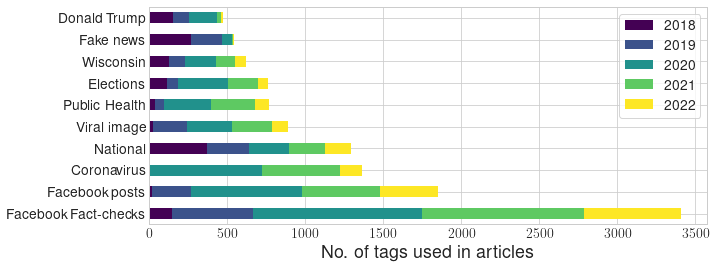

In [293]:
top_10_tags = tag_df.loc[top_10_tags, :].iloc[:,-5:]

fig1 = top_10_tags.plot(kind='barh', stacked=True, colormap='viridis')
fig1.legend(frameon=True)
fig1.set_xlabel('No. of tags used in articles')
plt.savefig('figs/fig1_top_10_tags.pdf', bbox_inches = "tight")

In [294]:
# Drop observations with different scale
df_temp = df_temp[~df_temp['Meter'].isin(['full-flop', 'half-flip', 'no-flip'])]

cat_by_date = {}

# Extract and count tags used in article by date
for date in df_temp['Date'].unique():
    df_new=df_temp[df_temp['Date']==date]
    tag_values = pd.Series(df_new['Meter']).value_counts()
    cat_by_date[date] = tag_values #Make dictionary: Key = date. Value is count of statement classification (pants-on-fire, false, true etc)
   


cat_by_date = dict(sorted(cat_by_date.items())) #Sort the dict by date

reorder_list = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire'] #define order of sorting to dataframe

df_cat = pd.DataFrame(cat_by_date).fillna(0)
df_cat = df_cat.reindex(reorder_list) #reorder according to above list

In [295]:
df_cat_dev_cuma = df_cat.iloc[:, :]\
    .cumsum(axis=1)

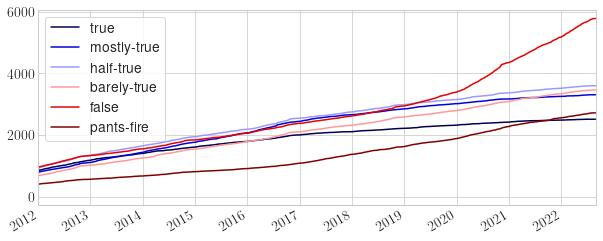

In [296]:
cat_plot = df_cat_dev_cuma.T.iloc[:, :].plot(colormap='seismic')
cat_plot.legend(frameon=True)
cat_plot.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2022-08-31'))
plt.savefig('figs/fig2.pdf', bbox_inches='tight')

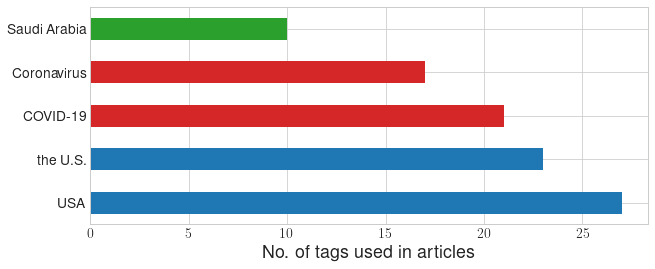

In [297]:
tag_values = pd.Series([x for list in data_pdn_for_clean['Tags'] for x in list]).value_counts()

fig3 = tag_values[:5].plot(kind='barh', color=['tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:green'])
fig3.set_xlabel('No. of tags used in articles')
plt.savefig('figs/fig3_top5tags_pdn.pdf', bbox_inches='tight')

In [357]:
import nltk
from nltk.probability import FreqDist

def word_count_prep(document):

    # Lowercase and remove non-alphanumeric characters
    document = document.lower()
    document = re.sub(r'[^\w\s]', ' ', document)

    # Tokenize 
    document_tokens = nltk.tokenize.word_tokenize(document)

    # Delete stop-words
    document_nostop = [i for i in document_tokens if i not in nltk.corpus.stopwords.words('english')]


    return document_nostop

lemz_pdn = data_pdn_for_clean['Article'].apply(word_count_prep)
lemz_pf = data_pf['Quote'].apply(word_count_prep)

In [366]:
all_words_pdn = []

for word_list in lemz_pdn:
    all_words_pdn += word_list

mostcommon_pdn = FreqDist(all_words_pdn).most_common(5)

In [367]:
all_words_pf = []

for word_list in lemz_pf:
    all_words_pf += word_list

mostcommon_pf = FreqDist(all_words_pf).most_common(5)

In [368]:
mostcommon_pdn
x_pdn, y_pdn = zip(*mostcommon_pdn)

In [369]:
x_pf, y_pf = zip(*mostcommon_pf)

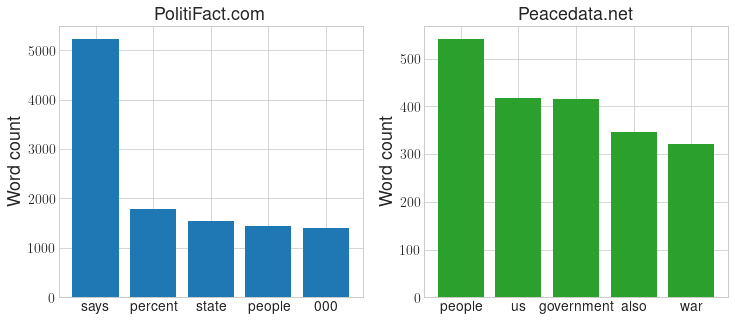

In [384]:
f_words, ax = plt.subplots(1,2, figsize=(12, 5))


ax[0].bar(x_pf, y_pf, color='tab:blue')
ax[0].set_title("PolitiFact.com")
ax[0].set_ylabel('Word count')
ax[1].bar(x_pdn, y_pdn, color='tab:green')
ax[1].set_title("Peacedata.net")
ax[1].set_ylabel('Word count')

plt.savefig('figs/word_count.pdf', bbox_inches='tight')

## Analysis

Define functions: 

In [298]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score as acc 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [299]:
def partition(df, true, fake): 
    
    part = df[df['Meter'].isin(true + fake)]
    part['Fake'] = part['Meter'].isin(fake).astype(int)

    return part

def prepare(document):

    # Lowercase and remove non-alphanumeric characters
    document = document.lower()
    document = re.sub(r'[^\w\s]', ' ', document)

    # Tokenize 
    document_tokens = nltk.tokenize.word_tokenize(document)

    # Delete stop-words
    document_nostop = [i for i in document_tokens if i not in nltk.corpus.stopwords.words('english')]

    # Lemmatize 
    document_lemmatized = [nltk.WordNetLemmatizer().lemmatize(i) for i in document_nostop]
    
    # Covert from list back to string 
    document = ' '.join(document_lemmatized)
    
    return document 

### Partitioning:

In [300]:
part1 = partition(data_pf, ['true'], ['pants-fire'])
X1 = part1['Quote'].apply(prepare).values 
y1 = part1['Fake'].values

part2 = partition(data_pf, ['true', 'mostly-true'], ['pants-fire', 'false'])
X2 = part2['Quote'].apply(prepare).values 
y2 = part2['Fake'].values

part3 = partition(data_pf, ['true', 'mostly-true', 'half-true'], ['pants-fire', 'false', 'barely-true'])
X3 = part3['Quote'].apply(prepare).values 
y3 = part3['Fake'].values

In [301]:
X1_dev, X1_test, y1_dev, y1_test = train_test_split(X1, y1, test_size=1/3, random_state=1337)
X1_train, X1_val1, y1_train, y1_val = train_test_split(X1_dev, y1_dev, test_size=1/2, random_state=1337)

X2_dev, X2_test, y2_dev, y2_test = train_test_split(X2, y2, test_size=1/3, random_state=1337)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_dev, y2_dev, test_size=1/2, random_state=1337)

X3_dev, X3_test, y3_dev, y3_test = train_test_split(X3, y3, test_size=1/3, random_state=1337)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_dev, y3_dev, test_size=1/2, random_state=1337)

### Learning curve

In [302]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [303]:
train_sizes1, train_scores1, test_scores1 = \
    learning_curve(estimator=pipe,
                   X=X1_dev,
                   y=y1_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='accuracy',                 
                   cv=10)

train_sizes2, train_scores2, test_scores2 = \
    learning_curve(estimator=pipe,
                   X=X2_dev,
                   y=y2_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='accuracy',                 
                   cv=10)

train_sizes3, train_scores3, test_scores3 = \
    learning_curve(estimator=pipe,
                   X=X3_dev,
                   y=y3_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='accuracy',                 
                   cv=10)

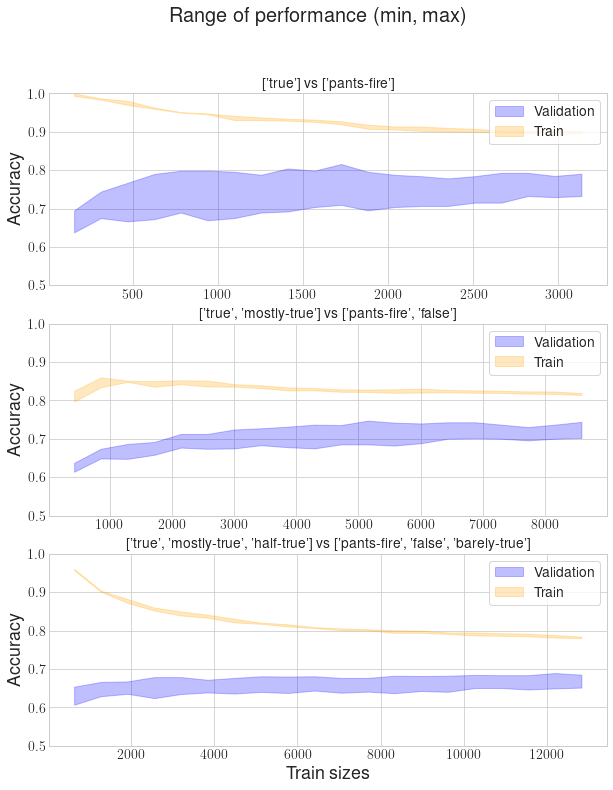

In [304]:
f_learn, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].fill_between(train_sizes1, test_scores1.min(1), test_scores1.max(1), alpha=0.25, label ='Validation', color='blue')
ax[0].fill_between(train_sizes1, train_scores1.min(1), train_scores1.max(1),  alpha=0.25, label='Train', color='orange')
ax[0].set_title("['true'] vs ['pants-fire']")
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.5,1])
ax[0].legend(frameon=True)

ax[1].fill_between(train_sizes2, test_scores2.min(1), test_scores2.max(1), alpha=0.25, label ='Validation', color='blue')
ax[1].fill_between(train_sizes2, train_scores2.min(1), train_scores2.max(1),  alpha=0.25, label='Train', color='orange')
ax[1].set_title("['true', 'mostly-true'] vs ['pants-fire', 'false']")
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0.5,1])
ax[1].legend(frameon=True)

ax[2].fill_between(train_sizes3, test_scores3.min(1), test_scores3.max(1), alpha=0.25, label ='Validation', color='blue')
ax[2].fill_between(train_sizes3, train_scores3.min(1), train_scores3.max(1),  alpha=0.25, label='Train', color='orange')
ax[2].set_title("['true', 'mostly-true', 'half-true'] vs ['pants-fire', 'false', 'barely-true']")
ax[2].set_ylabel('Accuracy')
ax[2].set_ylim([0.5,1])
ax[2].set_xlabel('Train sizes')
ax[2].legend(frameon=True)


f_learn.suptitle('Range of performance (min, max)');
plt.savefig('figs/learning_curve.pdf', bbox_inches='tight')

### Validation curve:

In [305]:
lambdas = np.logspace(-4, 4, 50)
Cs = 1/lambdas



train_scores1_vc, test_scores1_vc = \
    validation_curve(estimator=pipe,
                     X=X1_dev,
                     y=y1_dev,
                     param_name='logisticregression__C', #built-in name of hyperparameter
                     param_range=Cs, #values to consider
                     scoring='accuracy',                 
                     cv=10)

train_scores2_vc, test_scores2_vc = \
    validation_curve(estimator=pipe,
                     X=X2_dev,
                     y=y2_dev,
                     param_name='logisticregression__C', #built-in name of hyperparameter
                     param_range=Cs, #values to consider
                     scoring='accuracy',                 
                     cv=10)

train_scores3_vc, test_scores3_vc = \
    validation_curve(estimator=pipe,
                     X=X3_dev,
                     y=y3_dev,
                     param_name='logisticregression__C', #built-in name of hyperparameter
                     param_range=Cs, #values to consider
                     scoring='accuracy',                 
                     cv=10)                 

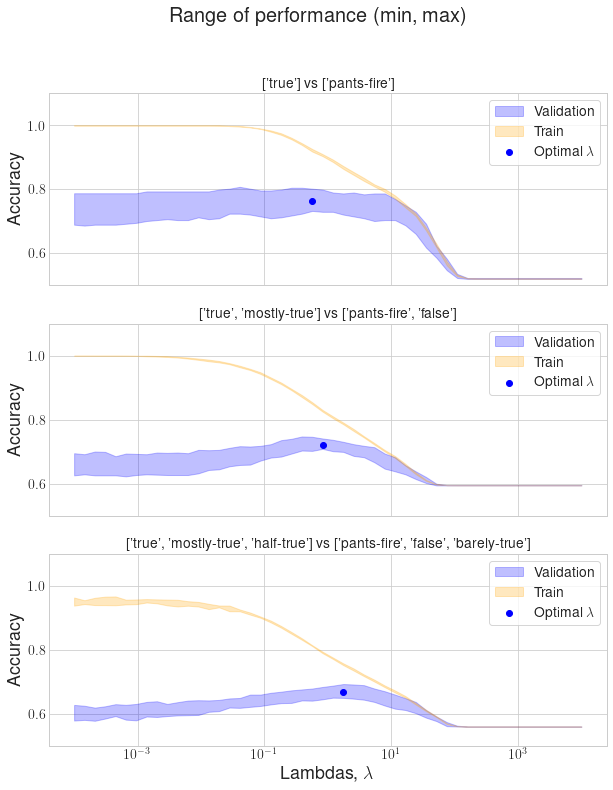

In [306]:
best_acc1 = max(test_scores1_vc.mean(axis=1))
best_lambda1 = 1/Cs[np.where(test_scores1_vc.mean(axis=1) == best_acc1)]
best_acc2 = max(test_scores2_vc.mean(axis=1))
best_lambda2 = 1/Cs[np.where(test_scores2_vc.mean(axis=1) == best_acc2)]
best_acc3 = max(test_scores3_vc.mean(axis=1))
best_lambda3 = 1/Cs[np.where(test_scores3_vc.mean(axis=1) == best_acc3)]

f_learn, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

ax[0].fill_between(1/Cs, test_scores1_vc.min(1), test_scores1_vc.max(1), alpha=0.25, label ='Validation', color='blue')
ax[0].fill_between(1/Cs, train_scores1_vc.min(1), train_scores1_vc.max(1),  alpha=0.25, label='Train', color='orange')
ax[0].scatter(best_lambda1, best_acc1, label='Optimal $\lambda$', color='blue')
ax[0].set_title("['true'] vs ['pants-fire']")
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.5,1.1])
ax[0].set_xscale('log')
ax[0].legend(loc='upper right', frameon=True)

ax[1].fill_between(1/Cs, test_scores2_vc.min(1), test_scores2_vc.max(1), alpha=0.25, label ='Validation', color='blue')
ax[1].fill_between(1/Cs, train_scores2_vc.min(1), train_scores2_vc.max(1),  alpha=0.25, label='Train', color='orange')
ax[1].scatter(best_lambda2, best_acc2, label='Optimal $\lambda$', color='blue')
ax[1].set_title("['true', 'mostly-true'] vs ['pants-fire', 'false']")
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0.5,1.1])
ax[1].set_xscale('log')
ax[1].legend(loc='upper right', frameon=True)

ax[2].fill_between(1/Cs, test_scores3_vc.min(1), test_scores3_vc.max(1), alpha=0.25, label ='Validation', color='blue')
ax[2].fill_between(1/Cs, train_scores3_vc.min(1), train_scores3_vc.max(1),  alpha=0.25, label='Train', color='orange')
ax[2].scatter(best_lambda3, best_acc3, label='Optimal $\lambda$', color='blue')
ax[2].set_title("['true', 'mostly-true', 'half-true'] vs ['pants-fire', 'false', 'barely-true']")
ax[2].set_ylabel('Accuracy')
ax[2].set_ylim([0.5,1.1])
ax[2].set_xscale('log')
ax[2].set_xlabel('Lambdas, $\lambda$')
ax[2].legend(loc='upper right', frameon=True)


f_learn.suptitle('Range of performance (min, max)');
plt.savefig('figs/validation_curve.pdf', bbox_inches='tight')

In [307]:
print(pd.DataFrame({'$Model_1$': [best_lambda1[0], best_acc1], '$Model_2$': [best_lambda2[0], best_acc2], '$Model_3$': [best_lambda3[0], best_acc3]}, np.arange(2)).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  \$Model\_1\$ &  \$Model\_2\$ &  \$Model\_3\$ \\
\midrule
0 &   0.568987 &   0.828643 &   1.757511 \\
1 &   0.764052 &   0.722117 &   0.667791 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_22052\906168421.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({'$Model_1$': [best_lambda1[0], best_acc1], '$Model_2$': [best_lambda2[0], best_acc2], '$Model_3$': [best_lambda3[0], best_acc3]}, np.arange(2)).to_latex())


### Topic modelling - peacedata.net

In [308]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df=0.1, max_features=5000)
bag = count.fit_transform(data_pdn_for_clean['Article'].values)

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5,random_state=123) #The random_state parameter pass an integer that makes the result reproducible 
review_topics = lda.fit_transform(bag)

n_top_words = 5
word_names = count.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_): #lda.components_ stores a matrix containing the word importance for each topic
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([word_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))

Topic 1:
turkey journalists immigration migrants qaeda
Topic 2:
yemen assange britain coalition eu
Topic 3:
fox mau sexual kenya exarcheia
Topic 4:
muslims henderson opcw pakistan hong
Topic 5:
amazon adani color gas project


Proceed with partition 2 - ['true', 'mostly-true'] vs ['false', 'pants-fire']
- It's the most logical (?) 

In [310]:
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(random_state=1337, C=1/best_lambda2[0])
tfidf = TfidfVectorizer()

X2_dev_bag = tfidf.fit_transform(X2_dev)
X2_test_bag = tfidf.transform(X2_test)

lr_fake_news = lr.fit(X2_dev_bag, y2_dev)
y2_preds = lr.predict_proba(X2_test_bag)

In [311]:
print('The bias term is:', lr.intercept_[0])

The bias term is: 0.7927012803034159


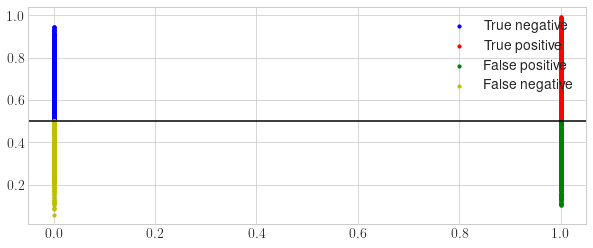

In [312]:
true_pos = []
true_neg = []
false_pos = []
false_neg = []

i=0

for prob in y2_preds:
    if (prob[0]>prob[1]) & (y2_test[i] == 0):
        true_neg.append(prob[0])
    elif (prob[1]>prob[0]) & (y2_test[i] == 1):
        true_pos.append(prob[1])
    elif (prob[1]>prob[0]) & (y2_test[i] == 0):
        false_pos.append(prob[0])
    elif (prob[0]>prob[1]) & (y2_test[i] == 1):
        false_neg.append(prob[1])
    i+=1

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.scatter(y=true_neg, x=[0]*len(true_neg), s=10, c='b', label='True negative')
ax1.scatter(y=true_pos, x=[1]*len(true_pos), s=10, c='r', label='True positive')
ax1.scatter(y=false_pos, x=[1]*len(false_pos), s=10, c='g', label='False positive')
ax1.scatter(y=false_neg, x=[0]*len(false_neg), s=10, c='y', label= 'False negative')
ax1.axhline(y=0.5, color='k')
plt.legend(loc='upper right');
plt.show()

In [313]:
from sklearn.metrics import confusion_matrix
y2_preds_binary = []
i=0
for prob in y2_preds:
    if (prob[0]>prob[1]) & (y2_test[i] == 0):
        y2_preds_binary.append(0)
    elif (prob[1]>prob[0]) & (y2_test[i] == 1):
        y2_preds_binary.append(1)
    elif (prob[1]>prob[0]) & (y2_test[i] == 0):
        y2_preds_binary.append(1)
    elif (prob[0]>prob[1]) & (y2_test[i] == 1):
        y2_preds_binary.append(0)
    i+=1

confusion_matrix(y2_test, y2_preds_binary)

array([[1103,  847],
       [ 527, 2294]], dtype=int64)

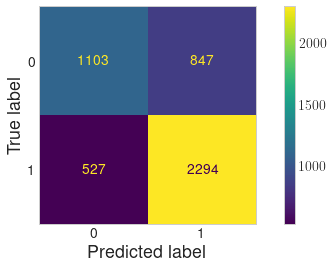

In [314]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr, X2_test_bag, y2_test)
plt.grid(False)
plt.savefig('figs/confusion_matrix.pdf', bbox_inches='tight')
plt.show()

In [315]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names_out()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,00,000,02,024,025,033,039,05,062,07,...,zoning,zoo,zoom,zti,zuber,zucker,zuckerberg,zyphr,ángeles,único
0,-0.1385,-1.24317,0.187876,-0.1012,0.043922,-0.150365,0.020257,-0.242118,0.095514,0.120877,...,0.076098,0.007167,0.153371,0.11338,0.055513,0.036038,0.660034,0.057121,0.056502,0.073275


In [316]:
X_pdn = data_pdn_for_clean['Article'].apply(prepare).values #Cleaning our PeaceData.net data, like we did with PolitiFact.com

In [317]:
pdn_bag = tfidf.transform(X_pdn) #Make our bag of words
pdn_preds = lr.predict_proba(pdn_bag) #From our previously fitted model on PolitiFact.com, we predict the probabilities of fake or true news

In [318]:
pdn_preds_df = pd.DataFrame(pdn_preds) #We then make a dataframe from our predictions. Our predictions are an array.
pdn_preds_df.head(n=3) #Column 0 is 'true' and 1 is 'fake'

,0,1
0,0.771655,0.228345
1,0.654998,0.345002
2,0.445306,0.554694


In [319]:
most_true_article_pdn_index = pdn_preds_df[0].idxmax() #Returns the index of the article w/ highest prob of being 'true'
most_true_article_pdn_prob = 1-pdn_preds_df[0].max() #Returns the lowest probability value for a fake article 
most_true_article_pdn_URL = data_pdn_for_clean['URL'].loc[most_true_article_pdn_index] #Returns the URL for the most true article
most_true_article_pdn_title = data_pdn_for_clean['Title'].loc[most_true_article_pdn_index] #Returns the title for the most true article

In [320]:
most_fake_article_pdn_index = pdn_preds_df[1].idxmax() #Returns the index of the article w/ highest prob of being 'fake'
most_fake_article_pdn_prob = pdn_preds_df[1].max() #Returns the highest probability value for a fake article
most_fake_article_pdn_URL = data_pdn_for_clean['URL'].loc[most_fake_article_pdn_index] #Returns the URL for the most true article
most_fake_article_pdn_title = data_pdn_for_clean['Title'].loc[most_fake_article_pdn_index] #Returns the URL for the most true article

In [321]:
#Make Latex table
print(pd.DataFrame({'Most fake article': [most_fake_article_pdn_title, most_fake_article_pdn_prob],\
     'Most true article': [most_true_article_pdn_title, most_true_article_pdn_prob]}, np.arange(2)).to_latex())

\begin{tabular}{lll}
\toprule
{} &                                  Most fake article &                                  Most true article \\
\midrule
0 &  \#CNNIsTrash Trends As Pushback Grows Against O... &  US Workers, Minorities Continuously Face Housi... \\
1 &                                           0.889415 &                                           0.028855 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_22052\2283369003.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({'Most fake article': [most_fake_article_pdn_title, most_fake_article_pdn_prob],\


In [322]:
pdn_list = []

i=0
for prob in pdn_preds:
    if (prob[0]>prob[1]):
        pdn_list.append('True')
    elif (prob[1]>prob[0]):
        pdn_list.append('Fake')
    i=+1
fake_count_pdn = pdn_list.count('Fake')
true_count_pdn = pdn_list.count('True') 

In [323]:
print('Count of "fake news" at PeaceData.net:', fake_count_pdn, '\nCount of "true news" at PeaceData.net:', true_count_pdn)

Count of "fake news" at PeaceData.net: 69 
Count of "true news" at PeaceData.net: 85


In [385]:
our_text = """Introduction
In light of the 2016 US election, ’fake news’ as a phenomenon rose to global attention.
Were it not for this intentional interference, it has been suggested that Hillary
Clinton would have pipped Donald Trump to become the 45th President of The
United States, see Parkinson (2016) and Dewey (2016). This begs the question:
What can we do to detect this spread of false information? One possibility is to
employ machine learning techniques. Specifically, our goal with this paper is: How
precisely can we automatically detect ’fake news’ using supervised machine learning?
We do this by leveraging scraped data of fact checked news stories and statements
from PolitiFact.com to train our supervised machine learning model.
One may ask how do we define fake news? Kshetri and Voas (2017) break up
false information in two sub branches: disinformation and misinformation. Dis-
information is false information spread to intentionally deceive, manipulate and
mislead. Misinformation, on the other hand, is simply wrong information provided
unintentionally or information perceived erroneously, for example that all classes at
University of Copenhagen start at 8.00 sharp and not actually 15 minutes later. Like
Kshetri and Voas (2017), we define ’fake news’ as disinformation typically produced
manually by individuals and/or state entities with the intention to deceive readers.
Our model classifies statements with an accuracy of 70-80 pct. on our test data
set from PolitiFact, depending on the model specification. We apply our classifica-
tion model on text data from PeaceData.net, a short-lived website that was banned
from Twitter and Facebook. This site was owned by the Internet Research Agency,
an entity that has proven connections to the Russian state (DiResta et al. 2019).
Our model classifies 69 out of 154 articles as ’fake’ news.
This paper adds to the growing literature on ’fake news’ and its implications for
the political climate and outcomes. This includes Allcott and Gentzkow (2017), who
take a theoretical approach by discussing the economics of fake news and sketches
a model that illustrates why fake news appears in the media landscape. They find
that pro-Trump fake stories were shared on Facebook a total of 30 million times
in the lead-up to the 2016 US election, significantly more than fake pro-Clinton
stories. Reis et al. (2019) employ more advanced machine learning models to detect
fake news. They achieve around 85 pct. accuracy in a random forest model with
supervised learning using human annotated BuzzFeed news articles relating to the
2016 US election. Reis et al. (2019) make use of 141 different textual features, which
include bag-of-words, like we do, and psycholinguistic features that capture biased
and persuasive language.
2

This paper is structured as follows: Section 2 goes into detail how we have ac-
quired the data, the ethics involved doing this and some descriptive statistics. In
Section 3, we describe the methodical approach to the supervised machine learning
model. In Section 4, we present our results, including evaluation of model perfor-
mance, and in section 5 we summarize and conclude.
2 Data
To investigate our research question, we collected data from PolitiFact, a website
constructed by the Poynter Institute specifically to fact check statements, articles
and social media posts from politicians and the general public. The fact checking
process is done by ’real’ journalists and thus is ideal for supervised machine learning
techniques, provided that we adhere to the terms of use.
We supplement our analysis by collecting data from Peacedata.net, a now-
defunct news website owned by the Internet Research Agency (IRA). IRA is an
entity directly linked to the Russian state with the intention to spread disinforma-
tion and interfere with US elections (DiResta et al. 2019). The motivation behind us
including Peacedata.net in our analysis is how they specifically tried (and in some
cases succeeded) to recruit Western journalists to write columns for them, as long
as they were focused on ”anti-war, anti-corruption, abuse of power, or human rights
violations” (Delaney 2020; Stubbs 2020). And so, it would be interesting to see
which stories, if any, our model predicts to be ’fake’.
2.1 Collection
In general, we have focused on creating ’custom’ functions that concisely illustrate
our approach with ample documentation to follow. Crucially, whenever we made a
request to scrape a webpage, we had to define a ’header’ in a dictionary format. This
dictionary had our names and non-commercial/academic intentions for acquiring
data via scraping. Further, we integrated the use of log functions and auxiliary
’error’ lists to inspect pages, where the scraping process did not go to plan.1
2.1.1 PolitiFact.com
To scrape PolitiFact, we made use of the requests package in Python. This pack-
age allows us to send HTTP (HyperText Transfer Protocol) requests to obtain the
1. We acknowledge and thank the lecturers/TA’s from the course Introduction to Social Data
Science at University of Copenhagen for making codes publicly available.
3
underlying HTML (HyperText Markup Language) code of the webpage in ques-
tion. The Beautiful Soup 4 package then allowed us to navigate the HTML-code
and pull out the desired data. The HTML-code of the PolitiFact website has a
fairly logical composition and so the scraping process was relatively smooth. First,
we accessed the latest fact checks by PolitiFact which contains all fact checks in
chronological, split up in 728 pages. We made a list of these 728 unique URL’s
and then looped through each page, extracting all information from the headline
of every article: Date, statement, classification and link to the article. Throughout
the webscraping process, we made sure to backup the collected data, as to avoid
unnecessary ’re-scraping’. We stored backups and data in general in the fast and
efficient file format of Apache Parquet, which also stores data types (Vohra 2016).
Finally, PolitiFact also checks whether politicians did go back on their promises
and/or statements made in the past. We drop these articles, as they do not suit a
supervised fake news detection model.
Next, we looped through every article extracting the article paragraphs, sources,
the journalist’s conclusion and tags associated with each article. Here, we made
use of the URL we scraped earlier to avoid using dynamic tools, e.g., the Selenium
package in Python. We estimated that this would have substantially slowed the pro-
cess. In the end, we ended up with 21,000 articles, with each statement categorized
on a scale from ”true news” to ”fake news”, namely the categories ’true’, ’mostly
true’, ’half-true’, ’barely true’, ’false’, and ’pants-on-fire’.
2.1.2 Peacedata.net
Scraping Peacedata.net was a bit of a challenge. As the website no longer exists
in its ’news form’, we scraped The Web Archive for available snapshots. We find
snapshots available from April 2020 to the end of September 2020, before it was
effectively shut down. This can be done by using The Web Archive’s API with a
specified date range, fetching a JSON file with a list of ’available’ URLs (Pezoa
et al. 2016). With these, we followed the same approach as with PolitiFact and
used requests and BeautifulSoup to obtain the HTML-code for the Peacedata.net
webpages. As (i) these URLs are snapshots of Peacedata.net’s front page at different
times, and (ii) the HTML-code is slightly finicky to assess, we concluded that this
had limited use to us. Instead, we extracted links to individual articles where we
could (and avoid any dynamic JavaScript content). From these links, we scraped
the title, article text, and dates where possible. This leaves us with a dataset of 154
articles after removing duplicated articles.
4
2.2 Ethics
Scraping data on the internet poses crucial questions to the terms of use. As a rule-
of-thumb, you are not allowed to webscrape with for commercial purposes. Further,
given the recent adoption of the General Data Protection Regulation (GDPR) in the
EU, the concern of enforcing privacy rights has become a much debated topic in the
public domain, particularly in light of the Facebook-Cambridge Analytica scandal
(Illing 2018).
In general we think we adhere to two main rule-of-thumbs; (i) we clearly state
our intentions in a header when requesting information from the web server, and (ii)
we do not store any private information nor do make any attempt in trying to find
this information that may or may not be publicly available.
The two sites has slightly different terms of use. PolitiFact states that the site’s
content is for your personal, non-commercial use, which we completely and transpar-
ently adhere to. Additionally, we are not allowed to use the material for ’unlawful
purposes’, like to track down and post defamatory material guided towards, say, the
journalists at PolitiFact. It becomes slightly complicated for Peacedata.net. As the
site only exists in ’snapshot’ form from The Web Archive, how can we ensure that
we comply with the terms of use? Interestingly, Peacedata.net would very openly
share they had a Creative Commons license in each article. In essence, this im-
plied royalty-free open-use of article content, provided that you attributed properly
(Commons 2022). In this regard, we are convinced that we adhere to these terms,
even though they no longer are in effect. Looking at the terms of use from The
Web Archive, it is stated that access to the archive is provided free of charge. Use
of any content from the archive is for scholarship and research purposes only. In
conclusion, we assess that we adhere to the terms of use where applicable.
Finally, we tried to comply with potential robots.txt-files, which specifies what
webcrawlers are allowed to access on a given website. Neither PolitiFact or The Web
Archive have specified any robots.txt-files, and interestingly, The Web Archive
made a blog post stating that ”Robots.txt meant for search engines don’t work well
for web archives.” Hence, with webscraping intentions of solely academic character,
we feel certain that we comply with their regulations.
2.3 Descriptive statistics
To provide a visualize representation of our datasets, we make a few descriptive
plots. From Figure 1, we see that Facebook is by far the most widely used tag in PolitiFact’s fact-checking articles in the last five years.2 This includes fact checking
videos, posts or statements made on the social media platform. Interestingly, the
’Coronavirus’ tag is third most used tag in the last five years, despite only being an
actual subject in the last two years with over 1,300 tags in total and over 600 tags
in 2020 alone. One can see that Donald Trump, fake news and elections has also
been ever present in PolitiFact’s fact checking in the last five years Figure 2 depicts the cumulative development in PolitiFact’s statement classifi-
cation, where we find a somewhat evenly distribution before 2020, except for the
’pants-on-fire’ classification. Even in the lead-up to the 2016 US election, PolitiFact
did not identify an abnormal amount of untrue statements. Of course, this may
be due to selection. Interestingly, in 2020, the amount of statements classified by
PolitiFact as ’false’ surges to almost 6000 in total, with around 2000 coming in the
last two years or so.
While we do not nearly have the same sample size for the Peacedata.net dataset,
it is clear from Figure 3 that issues fact checked by PolitiFact is more-or-less the
same issues most commonly found by the articles scraped from Peacedata.net. This
ties in well with the most common words used by PolitiFact and Peacedata.net from
Figure 4. The word ’people’ and ’state’/’government’ can even be found in both
PolitiFact and PeaceData’s most common words. Given that PolitiFact are mostly
quotes, it makes that the most common found here is ’says’. Finally, at a glance
the most used words from Peacedata seem to have more assertive connotations than
what is found in the PolitiFact dataset.
2. This figure and all figures to come are made with the pandas, seaborn, and
matplotlib.pyplot packages in Python (McKinney et al. 2010; Waskom 2021; Hunter 2007).
6
3 Methodology
This section explains the route from data to results (McKinney et al. 2010). It
will cover the basics behind working with text as data, the various packages used
and calculations made in Python and the theory of the (penalized) logistic regression
model. This route and its different steps closely follows Raschka and Mirjalili (2019)
and are depicted in Figure 5. Throughout the analysis, we make use of the numpy,
pandas, sklearn, and tqdm packages (Harris et al. 2020; McKinney et al. 2010;
Pedregosa et al. 2011) 3.1 Text as Data
In order for us to infer meaningful predictions, we had to appropriately clean our
text data. As is standard, we converted every letter to lower case to avoid iden-
tical words being interpreted differently. We then removed HTML-markup and
non-alphanumeric characters with Regular Expression Operations, (re) – a stan-
dard package in Van Rossum (2020). Next, we took advantage of the extensive
library of Natural Language Toolkit, nltk (Bird et al. 2009). Specifically, we use
the their tokenize package to divide the text (or the strings) of the articles into
lists of substrings, where, in our context, a substring is a word. Then, we use their
dictionary of English ”stopwords”, to remove words that carry next to no meaning
in the analysis, such as ”is”, ”the” and ”a”. The full list of stopwords can be found here. . Finally, we applied their lemmatizer to determine the lemma of the words,
i.e., align different conjugations and word endings, such that the words are grouped
based on their meaning and not their grammatical form. This procedure follows
Jurafsky and Martin (2018, ch. 2.4).
Then, after cleaning the strings, we take the bag-of-words approach, which ”al-
lows us to represent text as numerical feature vectors” (Raschka and Mirjalili 2019, p.
262). The first step is to count the occurrence of each word, and then, secondly, as-
sess the word relevancy with the term frequency-inverse document frequency (tfidf)
technique. The approach is carried out by applying the TfidfVectorizer from
Pedregosa et al. (2011) (see section 6.2.3.4 in the documentation for details).
3.2 Machine Learning and the Logistic Regression Model
To classify statements from the PolitiFact as either ’true’ or ’fake’, we use logistic
regression. Given that we map a binary classification problem, we are essentially in-
ferring ’probabilities’, e.g., p(y = 1|x), where our target variable y classifies whether
a statement or article is ’fake news’ (y = 1) or ’true’ (y = 0), and x is the features,
namely the vectorized bag of words. Obviously, these probabilities translate directly
into the predictions of the model – for p(y = 1|x) ≥ 0.5 ⇒ ˆy = 1. In the logis-
tic regression model, the conditional probabilities are calculated with the sigmoid
function (or, the inverse form of the logit function), which can be stated as
φ(z) = 1
1 + e−z (= p(y = 1|x), (1)
where z = wT x = w0 + w1x1 + ... + wmxm is the net input, i.e. m features with
corresponding weights, and a bias term w0. Later, when interpreting estimated
weights, it is worth noting that ˆy = 1 if z ≥ 0 and ˆy = 0 if z < 0.
In accordance with the theory of maximum likelihood estimation (MLE), the
weights are determined by maximizing the log-likelihood function:
ℓ(w) =
n∑
i=1
[yi log (φ(z)) + (1 − yi) log (1 − φ(z))] (2)
Actually, as is common practice in optimization problems, we will be minimizing
a cost function. Moreover, we will include a penalty term to alleviate issues with
”over-fitting” the data. The resulting cost function can be stated as
J(w) =
n∑
i=1
[yi log (φ(z)) + (1 − yi) log (1 − φ(z))] + λ
2 ||w||2
2, (3)
where λ is the regularization parameter, and 1
2 ||w||2
2 = 1
2 wT w is an L2-penalty,
which works by shrinking the absolute size of the weights.3
3. Note, that the logistic regression from sklearn uses the inverse regularization parameter
9
3.3 Model Selection
The binary outcome classification leaves us with a choice of how we want to train
our model. Given PolitiFact’s six-way classification from ’true’ to ’pants-on-fire’,
one may ask which classification of the PolitiFact statements to use. Do you only
train the model on true vs pants-on-fire statements? That is, statements that are
at ’opposite’ ends of the PolitiFact truth scale. Or do you include all 6 statement
classifications and lump them together in a binary outcome (fake vs true news)?
There is no clear answer to these questions, why we make three different partitions
of the full dataset and evaluate the performance of each of them. The partitions are
specified in Table 1. Worth noting is that these partitions not only influence the
total number of observations, but also the ratio between y = 1 and y = 0, cf. Figure
2. For each of these partitions, we follow Figure 5 and split the sets into training
sets and test sets. We will refer to the training sets in this step as the development
sets, as to avoid confusion between two different training sets later on.
Table 1: Dataset Partitions
y = 0 y = 1 n
true pants-on-fire 5, 227
true and almost true false and pants-on-fire 14, 311
true, almost true, and half-true barely true, false and pants-on-fire 21, 367
To illustrate the model performance for each development set in the dataset
partitions, Figure 6 visualizes validation and learning curves for the three different
model specifications. In the calculations of the learning and validation curves, we
have imposed a 10-fold cross validation step, in each step splitting the development
set into a training set and a validation set, again, in correspondence with Figure
5. The learning curve takes each training set and construct subsets of different
sizes, which are then fitted to and transformed by the Tfidf-Vectorizer to make
a bag-of-words. The bag is subsequently fitted to the Logistic Regression model.
This compound model (or pipeline) then takes both (the subset of) the training
C = 1/λ. This implies the following cost function (Pedregosa et al. 2011):
 ̃J(w) = C
n∑
i=1
[yi log (φ(z)) + (1 − yi) log (1 − φ(z))] + 1
2 ||w||2
2
This cost function and equation (3) are equivalent from an optimization standpoint, as the latter
is simply divided by λ (a constant), which is a linear transformation. We choose the formulation
with λ following Raschka and Mirjalili (2019).
10
set and the validation set as inputs to calculate predictions and evaluate accuracy
(accuracy(y, ˆy) = 1
n
∑n
i=1 1{ˆyi = yi}, where 1{·} is the indicator function).4 Sim-
ilarly, in the calculations of the validation curves, the training set is fitted and
predictions are made, but instead of varying the size of the training set, we now
vary the size of the hyperparameter, λ. For both types of curves, Figure 6 plots the
minimum and maximum accuracies obtained under the different calibrations. These
bands provide a quick view into the variance of the models, while actual confidence
intervals should be computed with Monte Carlo simulations, or similar. What is evidently clear from the learning curves in Figure 6 is that the model
does suffer from significant variance. While the ’true vs pants-on-fire’ model tend to
have the highest maximum accuracy, the 10-fold cross validation process highlights
how sensitive the model is to a particular partition of the dataset. For a training
sample size of 1, 500, the accuracy of the model jumps between 70-80 pct. depending
on the dataset partition. This is not surprising, given we have quite a small training
sample size of no more than 3, 500 statements for the ’true’ vs ’pants-on-fire’ model
specification.
The validation curves in Figure 6 in conjunction with Table 2 show the regulariza-
tion strength needed to achieve the highest accuracy for the different specifications.
4. Note, learning curves are calculated with sklearn’s baseline calibration of C = 1/λ = 1.
11
The optimal hyperparameter, λ, is calculated as the λ that gives the highest mean
accuracy of the validation set. As expected, the more items we include from the
PolitiFact scale, the higher the regularization parameter, λ, is needed to achieve
the highest accuracy. This makes intuitive sense. If we lump the whole scale in a
binary outcome, effectively fitting ambiguous statements that are classified as barely
true or half-true in our model, the noise in our dataset substantially increases. To
counteract this, we need to increase the regularization strength, or penalty term, to
avoid over-fitting.
Table 2: Optimal Hyperparameter and Corresponding Accuracy
Model 1 Model 2 Model 3
λi 0.569 0.829 1.758
Accuracy 0.764 0.722 0.668
Note: λi for i = 1, 2, 3 denotes the model that includes increasingly
more items on the PolitiFact fact check classification scale.
4 Results
In the previous section, we have visualized our datasets and trained a machine
learning model using logistic regression using different specific specification. The
diagnostics of each model specification illustrate the trade-off between variance and
red. The ’(True, Mostly true) vs (False, Pants-on-fire)’ model seem to strike the
best balance between accuracy and variance. This model hovers around 70 pct.
accuracy compared consistently under 70 pct. for the model that utilizes the full
Politifact statement scale. It is the model that we believe has the best trade-off
between increase in training sample and noise in the dataset. Discarding the middle
of the scale, i.e., barely true and half-true statements, makes intuitive sense. Is it
fair to classify ambiguous statements as wholeheartedly ’true’ or ’fake’ given that
we model a binary outcome?
Table 3 show the coefficient sizes of this particular model with the optimal hyper-
parameter, λ = 0.829. The larger the absolute coefficient size, the higher the impact
each word has on the predicted classification outcome. Interestingly, the common
denominator seem to be American politics and the COVID-19 pandemic. Words
such as ’biden’, ’pelosi’, ’vaccine’ and ’covid/coronavirus’ ”triggers” the algorithm
to predict a given statement to be fake. On the other hand, words such as ’percent’,
12
million’, ’growth’ - words that may have a ’quantitative’ tone - tends to the swing
the pendulum the other way, i.e., that statements typically are classified as ’true’.
The bias term is found to be 0.79. This implies that for a ’neutral’ statement, i.e.,
statements lacking impactful words, and only having features with coefficients close
to zero, the model tends to classify this as fake news.
Table 3: Most Impactful Words
Largest Smallest
biden 3.531 percent -3.201
show 3.001 since -2.627
vaccine 2.701 state -2.261
covid 2.478 half -2.224
photo 2.093 growth -1.900
pelosi 1.922 le -1.877
coronavirus 1.743 three -1.846
arrested 1.652 nation -1.738
say 1.625 million -1.738
democrat 1.608 six -1.716
Note: We find the bias (intercept) term to be 0.79.
4.1 Evaluating Performance The confusion matrix in Figure 7 shows the model performance graphically on our
test dataset. True positive (T P ) and true negatives (T N ) are instances where our
model correctly predicts statements as either fake (T P ) or true (T N ). Statements
13
that are incorrectly labelled as fake news are fake positives (F P ) and statements
incorrectly labelled as true are called fake negatives (F N ). In Figure 7 the areas
are TN, FP, FN, and TP in the direction of reading.
Furthermore, we calculate three model evaluation metrics:
P recision = T P
T P + F P = 0.73 (4)
Recall = T P
T P + F N = 0.81 (5)
Accuracy = T P + T N
T P + T N + F P + F N = 0.71 (6)
Precision essentially measures the fraction of which all news classified as ’fake’
are indeed fake. We obtain a precision of around 73 pct. However, it may simply
be that we may not have enough true statements to challenge the model for correct
predictions, i.e., that an artificially low false positive rate may boost precision.
The recall metric measures the fraction of all statements, which we know to be
’fake’, is correctly captured by our model. For 81 pct. of the fake news statements,
our model correctly labels them fake.
Accuracy is the overall measure of how well our model correctly labels fake news
as fake and true news as true in our test data set. Recall, that we have trained our
model on the (True, mostly true) vs (False, pants-on-fire). This model correctly
identifies 71 pct. of fake and true statements.
4.2 Model Application
Finally, we apply this trained model on the dataset from Peacedata.net obtained
through The Web Archive:
Table 4: PeaceData.net Classification Count
’Fake’ news 69
’True’ news 85
The model predicts that of the 154 articles from PeaceData.net, 69 of them
are ’fake news’. For illustration, we extract the most ’fake’ and ’true’ article from
Peacedata.net according to our predictions. These are found in Table 5 below:
Interestingly, we find that the article with the highest probability of being ’fake’
is about a Democratic presidential debate in Iowa aired on CNN in the lead-up
14
Table 5: Probabilities of Fake Articles from PeaceData.net
Most ’fake’ article Most ’true’ article
Title #CNNIsTrash Trends As Push-
back Grows Against Oligarchic
Election Meddling
US Workers, Minorities Contin-
uously Face Housing Insecurity
during the Pandemic
p(y = 1|x) 0.889 0.028
to the 2020 American election. When reading the story, it is difficult to conclude
whether this article is indeed fake, and we make no claim that it is despite our
results. The fact that the story is labelled as fake ties in well with the article’s
tags (’CNN’, ’Democratic Party’, ’the U.S.’) and the most impactful words from our
model in Table 3. At the other end of the scale, we find that an article about housing
insecurity during the pandemic has the lowest probability of being fake. Since the
article has quantitative keywords such as ’percent’ and ’growth’, the classification
seems plausible with the results from Table 3 in mind. Likewise, we make no claim
that this story is indeed ’true’, but only that our supervised machine learning flags
this as the least suspicious. A more sophisticated model that capture additional
linguistic features, such as the one found in Reis et al. (2019), is beyond the scope
of this paper and may yield different results. We leave this for future research.
5 Conclusion
In this paper, we scrape the website PolitiFact.com for their annotated fact-checked
statements. We are careful to adhere to their terms of use, which in short stipulate
that articles are used for non-commercial purposes only and with respect for the
right to privacy. These statements are carefully cleaned so that they can be used
in a supervised machine learning model that classifies statements via logistic regres-
sion. As PolitiFact has a six-way scale from pants-on-fire to true when classifying
statements, we need to make a choice for which specification to use. From our model
selection, we inspect the learning and validation curves which shows (i) all models
exhibits significant variance, and (ii) the more statements we include, the higher
the regularization is needed to achieve the highest accuracy and avoid over-fitting.
We argue that the model specification that disregard ambiguous statements that
are classified as either ’half-true’ or ’barely-true’ seems to strike the best balance
between bias, variance and accuracy. We then use this preferred model on our test
set (with no data leakage), and evaluate its performance.
15
Finally, we apply this model (with the optimal hyperparameter) on a subset of
articles from Peacedata.net, a website recently excluded from Facebook and Twitter
for their intentional disinformation approach. We scraped these from The Web
Archive. We assess that we adhere to the terms of use, given that access to the
archive is for research purposes only. Of 156 PeaceData.net articles, 69 are labelled
as ’fake’. We can trace back the two articles which have the highest probability of
being ’fake’ and ’true’ to the most impactful words found in our model of choice.
While we believe that our model produces sensible results, it does not come
without caveats and room for future research. Of particular interest is training the
model on much larger datasets of articles, expand the model to detect patterns of
words, e.g., with n-grams, and improve on the classification scheme, e.g, with a
multinomial logistic regression model.
We would like to emphasize that this relatively simple model merely serves to
show what text-as-data in conjunction with machine learning can do, rather to have
claimed that we have found the panacea to fake news detection.
16) """ 

In [388]:
our_text_cleaned = clean_text(our_text)

In [390]:
our_text_cleaned_prep = prepare(our_text_cleaned)

In [394]:
our_bag = tfidf.transform([our_text_cleaned_prep])

In [396]:
our_pred = lr.predict_proba(our_bag)

In [397]:
our_pred

array([[0.42661446, 0.57338554]])